# 1 Importing necessary libraries

Importing libraries and setting up device agnostic code

In [1]:
import pandas as pd
import numpy as np

import torch

from torch import nn

from pathlib import Path

import os

import random
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import shutil

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

from typing import Dict, List

from tqdm.auto import tqdm

from classes import CNN, CustomResizeAndSplit, ImageFolderWithPaths

In [2]:
# Set seed
random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 2 Getting Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_path = Path("/content/drive/MyDrive/datasets/Font_Classifier/data")

# 3 Data Preparation and Exploration

In [5]:
def walk_through_dir(dir_path):
    """Walks through dir_path, returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(data_path)

There are 10 directories and 0 images in '/content/drive/MyDrive/datasets/Font_Classifier/data'.
There are 0 directories and 76 images in '/content/drive/MyDrive/datasets/Font_Classifier/data/GreatVibes'.
There are 0 directories and 83 images in '/content/drive/MyDrive/datasets/Font_Classifier/data/AguafinaScript'.
There are 0 directories and 70 images in '/content/drive/MyDrive/datasets/Font_Classifier/data/Allura'.
There are 0 directories and 76 images in '/content/drive/MyDrive/datasets/Font_Classifier/data/Canterbury'.
There are 0 directories and 82 images in '/content/drive/MyDrive/datasets/Font_Classifier/data/Holligate Signature'.
There are 0 directories and 80 images in '/content/drive/MyDrive/datasets/Font_Classifier/data/James Fajardo'.
There are 0 directories and 73 images in '/content/drive/MyDrive/datasets/Font_Classifier/data/OpenSans'.
There are 0 directories and 72 images in '/content/drive/MyDrive/datasets/Font_Classifier/data/I Love Glitter'.
There are 0 directories a

## 3.1 Visualising an image

alsscrp
Random image path: /content/drive/MyDrive/datasets/Font_Classifier/data/alsscrp/image_4.png
Image class: alsscrp
Image_height: 79
Image width: 252


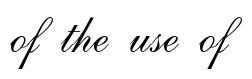

In [7]:
# Select all .png files in eache folder inside data_path
image_path_list = list(data_path.glob("*/*.png"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
print(image_class)

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image_height: {img.height}")
print(f"Image width: {img.width}")
img

# 4 Data Transformation

In [8]:
# Height and Width of the transformed image
HEIGHT = 64
WIDTH = 64

## 4.1 Splitting image

Splitting the image based on the specified dimension so as the image doesnt get distorted

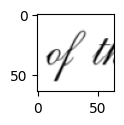

In [9]:
resize_and_split = CustomResizeAndSplit(size = (HEIGHT, WIDTH))
new_img = resize_and_split(img, 0)
plt.figure(figsize=(1, 1))
plt.imshow(new_img)

# 4.2 Data Transformation

In [10]:
# Transform for image
data_transform = transforms.Compose([

    # Turn the image to a tensor
    transforms.ToTensor()
])

In [11]:
def plot_transformed_images(image_paths: list, transform, n = 3, seed = 42):
    """
    Plots original and transformed images side by side.

    Args:
        image_paths (list): List of paths to the images to be plotted.
        transform (callable): A transformation function to be applied to the images.
        n (int, optional): Number of images to plot. Default is 3.
        seed (int, optional): Seed for random sampling. Default is 42.
    """

    if seed:
        random.seed(seed)

    # Selecting 3 random paths from all paths
    random_image_paths = random.sample(image_paths, k = n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:

            ncols = f.size[0] // f.size[1] + 1

            fig, ax = plt.subplots(nrows = 1, ncols = ncols)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            for i in range(ncols - 1):

                # Transform and plot the transformed image
                curr_f = resize_and_split(f, i)

                # Need to change the shape for matplotlib
                transformed_image = transform(curr_f).permute(1, 2, 0)
                ax[i + 1].imshow(transformed_image)
                ax[i + 1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

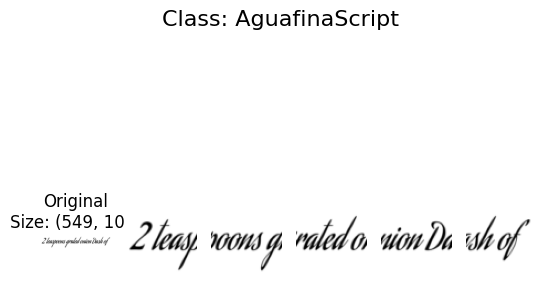

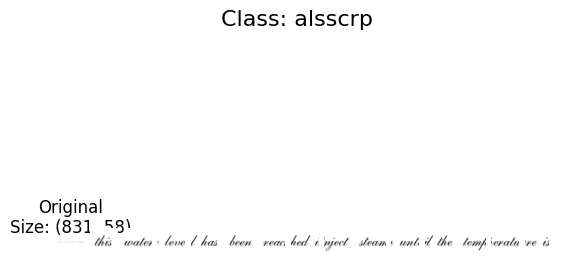

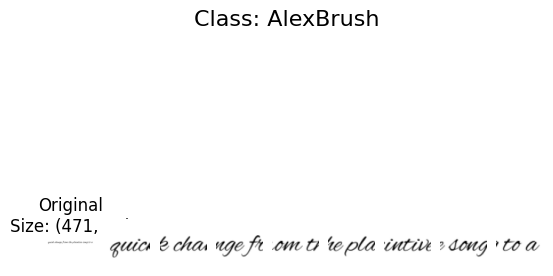

In [12]:
plot_transformed_images(image_paths = image_path_list, transform = data_transform, n = 3, seed = random.randint(0, 100))

# 5 Storing transformed data

In [13]:
def store_transformed_data(data_path, train_path, test_path):
    """
    Transforms and splits image data into training and testing sets.

    Args:
        data_path (str): Path to the directory containing the original data.
        train_path (str): Path to the directory where transformed training data will be stored.
        test_path (str): Path to the directory where transformed testing data will be stored.
    """
    for class_name in os.listdir(data_path):
        class_dir = os.path.join(data_path, class_name)

        if os.path.isdir(class_dir):

            # Creating directories for train and test dataset
            transformed_class_dir_train = os.path.join(train_path, class_name)
            transformed_class_dir_test = os.path.join(test_path, class_name)
            os.makedirs(transformed_class_dir_train)
            os.makedirs(transformed_class_dir_test)

            # Going through each file
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                img = Image.open(file_path)

                # Creating a random number to send the file into train or test folder
                rand_num = random.uniform(0, 1)

                # Number of files each file would be split into
                num_files =  int(HEIGHT / WIDTH *  img.size[0] / img.size[1])

                # Going through each split file
                for i in range(num_files):

                    # Splitting the image
                    transformed_img = resize_and_split(img, i)
                    new_file_name = file_name[:-4] + "_" + str(i) + file_name[-4:]

                    # 70% Probability of training
                    if rand_num < 0.7:
                        transformed_img.save(os.path.join(transformed_class_dir_train, new_file_name))

                    else:
                        transformed_img.save(os.path.join(transformed_class_dir_test, new_file_name))

In [14]:
transformed_data_path = Path("/content/drive/MyDrive/datasets/Font_Classifier/transformed_data")

# Create train and test paths
train_path = transformed_data_path / 'train'
test_path = transformed_data_path / 'test'

# Check if the directory exists
if transformed_data_path.exists():
    pass
else:
    os.makedirs(train_path)
    os.makedirs(test_path)

    store_transformed_data(data_path, train_path, test_path)

# 6 Loading transformed Data

In [15]:
train_dataset = ImageFolderWithPaths(root = train_path, transform = data_transform)
test_dataset = ImageFolderWithPaths(root = test_path, transform = data_transform)

In [16]:
class_names = train_dataset.classes
class_names

['AguafinaScript',
 'AlexBrush',
 'Allura',
 'Canterbury',
 'GreatVibes',
 'Holligate Signature',
 'I Love Glitter',
 'James Fajardo',
 'OpenSans',
 'alsscrp']

## 6.1 Turn image into Dataloader

In [17]:
BATCH_SIZE = 64
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = os.cpu_count(),
                              shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE,
                             num_workers = os.cpu_count(),
                             shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7eb2b78d58a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7eb2b47aeb30>)

In [18]:
len(train_dataloader), len(test_dataloader)

(68, 31)

In [19]:
img, label, path = next(iter(train_dataloader))

# Batch size will now be 64
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Image shape: torch.Size([64, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])


# 7 Creating Model

In [20]:
torch.manual_seed(42)
model_0 = CNN (input_shape = 3,         # Number of color channels in our data
               hidden_units = 10,
               output_shape = len(class_names)).to(device)
model_0

CNN(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=10, bias=True)
  )
)

In [21]:
image_batch, label_batch, path_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

## 7.1 Using torchinfo to get an idea of the shapes

In [22]:
# Install torchinfo, import if its available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.2 Creating train and test loop functions

### 7.2.1 Create train step

In [23]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
    """
    Performs a single training step for the model.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        dataloader (torch.utils.data.DataLoader): DataLoader for the training data.
        loss_fn (torch.nn.Module): Loss function to calculate the loss.
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        device (torch.device, optional): Device to perform the training on (default is CPU).

    Returns:
        tuple: Average training loss and accuracy over the dataloader.
    """

    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y, _) in enumerate(dataloader):

        # Send data to the target device
        X, y = X.to(device), y.to(device)

        # Forward Pass
        y_pred = model(X)

        # Calculate the loss
        loss = loss_fn (y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate the accuracy metric
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

### 7.2.2 Create test step

In [24]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: device):
    """
    Performs a single testing step for the model.

    Args:
        model (torch.nn.Module): The neural network model to be tested.
        dataloader (torch.utils.data.DataLoader): DataLoader for the test data.
        loss_fn (torch.nn.Module): Loss function to calculate the loss.
        device (torch.device): Device to perform the testing on (CPU or GPU).

    Returns:
        tuple: Average test loss, test accuracy, and full image accuracy over the dataloader.
    """

    # Put model in Eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    ctr = 0
    prev_image = 0
    acc = []

    # Turn on inference mode
    with torch.inference_mode():

        # Loop through data loader data batches
        for batch, (X, y, paths) in enumerate(dataloader):

            # Send data to the target device
            X, y = X.to(device), y.to(device)

            # List of images in this batch
            new_images = [os.path.basename(path) for path in paths]

            # Predicted logits
            test_pred_logits = model(X)

            # Loss values
            loss = loss_fn (test_pred_logits, y)
            test_loss += loss.item()

            # Predicted probabilities, labels and accuracy of each subimage
            test_pred_probs = torch.softmax(test_pred_logits, dim = 1)
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim = 1), dim = 1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_logits)

            # Looping through all subimages in the batch to find accuracy over images
            for i, image in enumerate(new_images):

                # Running the loop for the first time
                if ctr == 0:
                    ctr += 1
                    prev_image = image[:-6]
                    this_test_pred_probs = test_pred_probs[i]
                    prev_class = y[i]
                    continue

                this_image = image[:-6]

                # This and previous image belong to the same bigger image
                if this_image == prev_image:

                    # Adding predicted probabilities
                    this_test_pred_probs += test_pred_probs[i]
                    continue

                # This and previous image belong to different bigger subimage
                # Checking if the label for the previous image matches the class of the previous image
                # If yes, appending 1 to accuracy. Appending 0 otherwise
                prev_test_pred_label = torch.argmax(this_test_pred_probs, dim = 0)
                if prev_test_pred_label == prev_class:
                    acc.append(1)
                else:
                    acc.append(0)

                # Making preparations for the next loop
                prev_image = this_image
                this_test_pred_probs = test_pred_probs[i]
                prev_class = y[i]

        # Finding final values of loss and accuracy
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        full_image_acc = sum(acc) / len(acc)

    return test_loss, test_acc, full_image_acc

## 7.3 Creating a `train()` function to combine `train_step()` and `test_step()`

In [25]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
    """
    Trains and evaluates a PyTorch model.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        train_dataloader (torch.utils.data.DataLoader): DataLoader for the training data.
        test_dataloader (torch.utils.data.DataLoader): DataLoader for the test data.
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        loss_fn (torch.nn.Module): Loss function to calculate the loss (default: CrossEntropyLoss).
        epochs (int): Number of epochs to train the model (default: 5).
        device (torch.device): Device to perform the training and testing on (default: CPU).

    Returns:
        dict: A dictionary containing the training and testing loss and accuracy for each epoch.
    """

    # Create empty results dictionary
    results = {"train_loss": [],
              "train_acc": [],
              "test_loss": [],
              "test_acc": [],
               "full_image_test_acc": []}

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model = model,
                                          dataloader = train_dataloader,
                                          loss_fn = loss_fn,
                                          optimizer = optimizer,
                                          device = device)

        test_loss, test_acc, full_image_test_acc = test_step(model = model,
                                          dataloader = test_dataloader,
                                          loss_fn = loss_fn,
                                          device = device)

        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | test loss: {test_loss:.4f} | Test acc: {test_acc:.4f} | Full Image Test acc: {full_image_test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["full_image_test_acc"].append(full_image_test_acc)

    return results

## 7.4 Train and evaluate model_0

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 8

# Recreate an instance of CNN
model_0 = CNN(input_shape = 3,
              hidden_units = 10,
              output_shape = len(class_names)).to(device)


# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()

print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 2.0893 | Train acc: 0.2251 | test loss: 1.4131 | Test acc: 0.4750 | Full Image Test acc: 0.4453
Epoch: 1 | Train loss: 0.7873 | Train acc: 0.7422 | test loss: 0.5970 | Test acc: 0.8080 | Full Image Test acc: 0.8240
Epoch: 2 | Train loss: 0.4654 | Train acc: 0.8547 | test loss: 0.6133 | Test acc: 0.8117 | Full Image Test acc: 0.8453
Epoch: 3 | Train loss: 0.3622 | Train acc: 0.8969 | test loss: 0.4788 | Test acc: 0.8684 | Full Image Test acc: 0.9093
Epoch: 4 | Train loss: 0.3044 | Train acc: 0.9104 | test loss: 0.4877 | Test acc: 0.8753 | Full Image Test acc: 0.9093
Epoch: 5 | Train loss: 0.2599 | Train acc: 0.9279 | test loss: 0.4723 | Test acc: 0.8639 | Full Image Test acc: 0.8987
Epoch: 6 | Train loss: 0.2223 | Train acc: 0.9387 | test loss: 0.3952 | Test acc: 0.8916 | Full Image Test acc: 0.9280
Epoch: 7 | Train loss: 0.2028 | Train acc: 0.9427 | test loss: 0.4833 | Test acc: 0.8686 | Full Image Test acc: 0.9173
Total training time: 147.126 seconds


## 7.8 Plot the loss curves of Model 0

In [ ]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc', 'full_image_test_acc'])

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """
    Plots training curves of a results dictionary.

    Args:
        results (Dict[str, List[float]]): A dictionary containing the training and testing metrics.
            It should have keys: 'train_loss', 'test_loss', 'train_acc', 'test_acc', and 'full_image_test_acc'.
            Each key corresponds to a list of float values representing the metric values for each epoch.
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    # Get the accuracy values of the results dictionary
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    full_image_test_acc = results["full_image_test_acc"]

    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))

    # Setup a plot
    plt.figure(figsize = (15, 5))

    # Plot the loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, loss, label = "train_loss")
    plt.plot(epochs, test_loss, label = "test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, accuracy, label = "train_accuracy")
    plt.plot(epochs, test_accuracy, label = "test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot the full image test accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, full_image_test_acc, label = "full image test acc")
    plt.title("Full Image Test Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

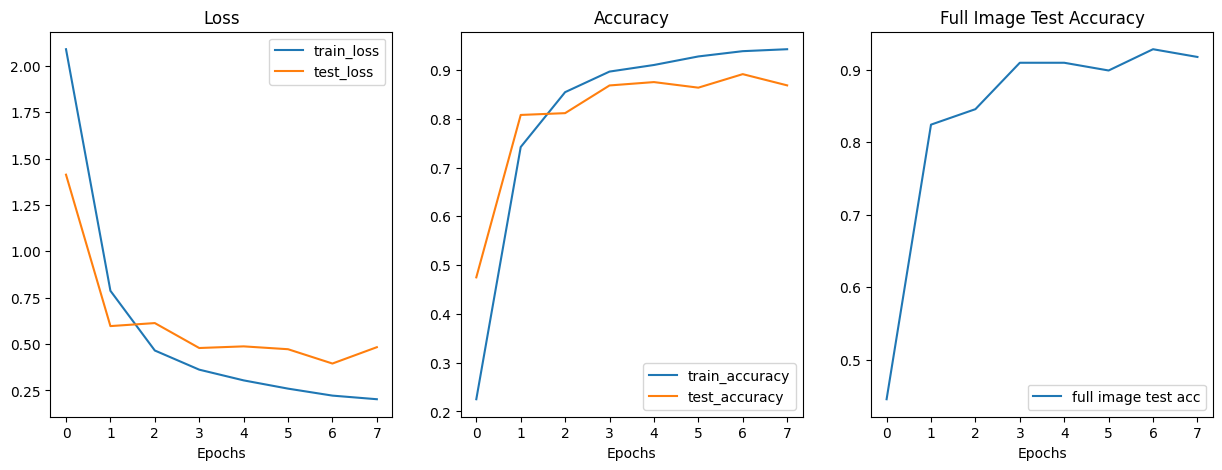

In [ ]:
plot_loss_curves(model_0_results)

# 8 Storing/Loading model weights

## 8.1 Storing the model

In [ ]:
from pathlib import Path
MODEL_PATH = Path("/content/drive/MyDrive/Saved_Models/Font_Classifier")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)
MODEL_NAME = "model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(model_0, MODEL_SAVE_PATH)

## 8.2 Loading the model

In [1]:
# Importing libraries again and redefining some variables, so that the code can be run from this point for evaluation

import torch
from pathlib import Path
from torch import nn

from PIL import Image

import os
import random

from torchvision import transforms

import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

MODEL_PATH = Path("/content/drive/MyDrive/Saved_Models/Font_Classifier")
MODEL_NAME = "model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

from classes import CNN, CustomResizeAndSplit, ImageFolderWithPaths

Mounted at /content/drive


In [2]:
model_0 = torch.load(MODEL_SAVE_PATH, map_location=torch.device(device))

# 9 Making predictions on unseen data

## 9.1 Redefining variables to run the model directly post loading

In [3]:
class_names = ['AguafinaScript',
 'AlexBrush',
 'Allura',
 'Canterbury',
 'GreatVibes',
 'Holligate Signature',
 'I Love Glitter',
 'James Fajardo',
 'OpenSans',
 'alsscrp']

HEIGHT = 64
WIDTH = 64

resize_and_split = CustomResizeAndSplit(size = (HEIGHT, WIDTH))

# Transform for image
data_transform = transforms.Compose([

    # Turn the image to a tensor
    transforms.ToTensor()
])

In [4]:
def predict(path: str,
            model: torch.nn.Module,
            class_names: list):
    """
    Generates predictions for images in the given directory using the provided model.

    Args:
        path (str): Path to the directory containing images.
        model (torch.nn.Module): The trained neural network model.
        class_names (list): List of class names for prediction labels.
    """

    # Set the model to eval mode
    model.eval()
    with torch.inference_mode():

        # Store predictions and file names in lists
        predictions = []
        file_names = []

        # Iterate through each file in the folder
        for file_name in os.listdir(path):
            file_path = os.path.join(path, file_name)
            img = Image.open(file_path)
            num_files =  int(HEIGHT / WIDTH *  img.size[0] / img.size[1])

            # Create an empty tensor for predictions
            preds = torch.zeros([1, 10]).to(device)
            for i in range(num_files):

                # Make transformations
                transformed_img = resize_and_split(img, i)
                transformed_img = data_transform(transformed_img)

                # Make predictions
                model = model.to(device)
                transformed_img = transformed_img.to(device)
                transformed_img_pred = model(transformed_img.unsqueeze(0)).to(device)
                preds += torch.softmax(transformed_img_pred, dim = 1)

            predictions.append(class_names[torch.argmax(preds, dim = 1).cpu()])
            file_names.append(file_name)

    df = pd.DataFrame({
        "Image": file_names,
        "Font": predictions
    })

    df.to_csv("Predictions.csv", index=True)
    print("All predictions written to csv")


In [5]:
predict_path = "/content/drive/MyDrive/datasets/Font_Classifier/Misc_Data"
predict(predict_path, model_0, class_names)

All predictions written to csv
